In [13]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from diff_dsp import *
from utils.utility import * 
from utils.logging import *
from utils.processing import *
import matplotlib.pyplot as plt
from model import ASPestNet
from losses import MSSpectralLoss

In [14]:
ds_path = '/Users/dalsag1/Documents/datasets/arni'
checkpoint_path = '/Users/dalsag1/Documents/transfer/diff-ar/20231025-205208/checkpoint/*'
rir_length = 1.8
sr = 48000
num = 120000


In [15]:
def load_rir(sr, rir_length, rir_path):
    rir, samplerate = sf.read(rir_path, dtype='float32')
    if samplerate!=sr:
        raise ValueError('Wrong samplerate: detected {} - required {}'.format(samplerate, sr))
    # if multichannel, take only the first channel
    if len(rir.shape)>1:
        print('Converting to mono by taking only the first channel')
        rir = rir[0, :]
    # adjust length 
    rir_len_samples = int(rir_length*sr)
    if rir.shape[0] > rir_len_samples:
        rir = rir[:rir_len_samples]
    elif rir.shape[0] < rir_len_samples:
        rir = np.pad(rir, 
        ((0, rir_len_samples - rir.shape[0])),
        mode = 'constant')

    # --------------- PREPROCESSING --------------- #
    # remove onset 
    onset = find_onset(rir)
    rir = np.pad(rir[onset:],(0, onset))
    # multply random gain to direct sound 
    rir = augment_direct_gain(rir, sr=sr)
    # nornalize 
    rir = normalize_energy(rir)
    return rir

def restore_checkpoint2(checkpoint_path, net, epoch = None, pattern = r'\d{4}'):
    ''' restore model from checkpoint of the network
    Args:    
        net     model to load the checkpoint onto
        epoch   epoch to be restored. If None, the latest checkpoint will be used
    '''    
    list_paths = glob(checkpoint_path)
    list_ids = [int(re.findall(pattern, weight_path)[-1])
                for weight_path in list_paths]
    if epoch is None:
        # find latest epoch
        filename = list_paths[max(list_ids)]
        epoch = max(list_ids)
    else:
        filename = list_paths[list_ids.index(epoch)]

    checkpoint = torch.load(filename, map_location=torch.device('cpu'))
    net.load_state_dict(checkpoint)
    return net, epoch

In [16]:
net = ASPestNet()

# check if checkpoint is available 
net, last_epoch = restore_checkpoint2(checkpoint_path, net)

# pathlist = [y for x in os.walk(ds_path) for y in glob(os.path.join(x[0], '*.wav'))]
# rir_path = pathlist[10]
rir_path = "/Users/dalsag1/Documents/transfer/diff-ar/20231025-205208/audio_output/target_ir.wav"
input = torch.tensor(load_rir(sr, rir_length, rir_path))
x = get_frequency_samples(int(np.floor(num/2)+1))  
# energy norm 
with torch.no_grad():
    _,ir_late, h0 = net(input.unsqueeze(0), x) 
    # compute the energy of early ir and late ir
    energy_h0 = torch.mean(torch.pow(torch.abs(h0),2), dim=1)
    energy_late = torch.mean(torch.pow(torch.abs(ir_late),2), dim=1)
    
    # match energy of early part to that of late part 
    # TODO This should be changes with a more meaningful scaling
    net.h0_norm.data.copy_(torch.div(
        net.h0_norm, torch.pow( torch.min(
            energy_h0/energy_late), 1/2)))

    # normalize energy of ir to equal 1 
    ir ,_, _ = net(input.unsqueeze(0), x)   
    energy = torch.mean(torch.pow(torch.abs(ir),2), dim=1)
    net.ir_norm.data.copy_(torch.div(net.ir_norm, torch.pow( torch.max(energy), 1/2)))
    # apply energy normalization on input and output gains only

target = input.clone()
ir, _, _ = net(input.unsqueeze(0), x)

criterion = MSSpectralLoss()
loss = criterion(ir, target)
print('Loss {}'.format(loss))

Loss 37.47377395629883


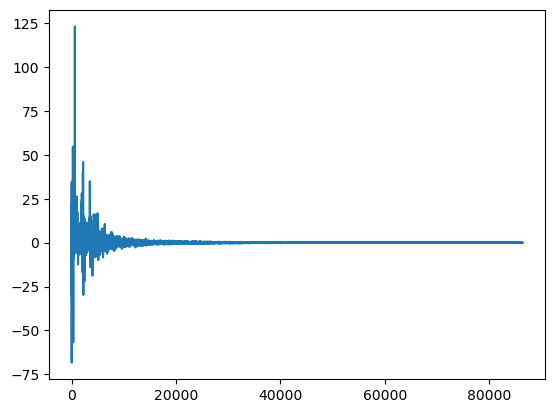

In [17]:
plt.plot(ir[0,:].detach().numpy())
plt.show()
rir_estimated = ir[0,:].detach().numpy()
rir_estimated = rir_estimated / np.max(np.abs(rir_estimated))
sf.write("/Users/dalsag1/Dropbox (Aalto)/aalto/projects/diff-delay-net/inference/ir_estimated.wav", rir_estimated,sr)

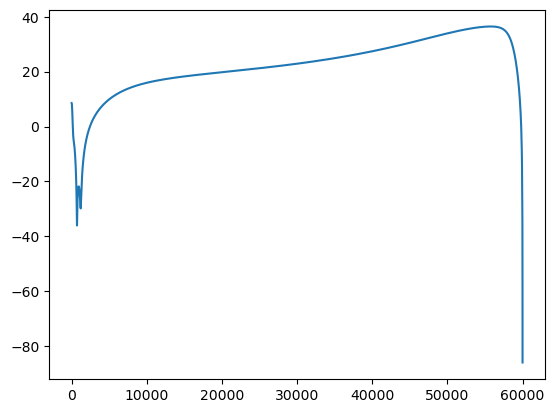

In [18]:
parameters, filters_tf = net.get_filters(input, x)
plt.plot(20*np.log10(np.abs(filters_tf['Cdelta'][0,:])))
plt.show()